# Acquire data

In [ ]:
!pip install yfinance

import pandas as pd
import numpy as np
import datetime

# import pandas_datareader.data as web
import yfinance as yf
from pandas import Series, DataFrame
import requests
from matplotlib import pyplot as plt


In [1]:
import pandas as pd
import numpy as np
import datetime

# import pandas_datareader.data as web
import yfinance as yf
from pandas import Series, DataFrame
import requests
from matplotlib import pyplot as plt


In [2]:
# Workaround to handle issue https://github.com/pydata/pandas-datareader/issues/868
USER_AGENT = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)"
        " Chrome/91.0.4472.124 Safari/537.36"
    )
}
sesh = requests.Session()
sesh.headers.update(USER_AGENT)


start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2020, 12, 31)

# btc_df = web.DataReader("BTC-USD", "yahoo", start, end, session=sesh)
btc_df = yf.download("BTC-USD", start=start, end=end)
btc_df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2014-09-17,457.334015,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,398.821014,412.425995,393.181000,408.084991,26580100


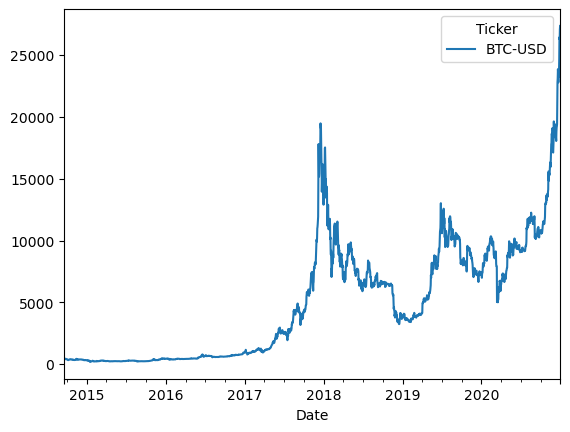

In [3]:
btc_df["Open"].plot()
resolution_value = 1200
plt.savefig("myImage.png", format="png", dpi=resolution_value)


In [4]:
btc_df["delta_pct"] = (btc_df["Close"] - btc_df["Open"]) / btc_df["Open"]

In [5]:
def rolling_window(a, window):
    """
    Takes np.array 'a' and size 'window' as parameters
    Outputs an np.array with all the ordered sequences of values of 'a' of size 'window'
    e.g. Input: ( np.array([1, 2, 3, 4, 5, 6]), 4 )
         Output:
                 array([[1, 2, 3, 4],
                       [2, 3, 4, 5],
                       [3, 4, 5, 6]])
    """
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


In [6]:
btc_df["going_up"] = (
    btc_df["delta_pct"].apply(lambda d: 1 if d > 0.00001 else 0).to_numpy()
)

In [7]:
element = btc_df["going_up"].to_numpy()

In [8]:
WINDOW_SIZE = 15

In [9]:
training_data = rolling_window(element, WINDOW_SIZE)

In [10]:
training_data

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int64)

In [11]:
pd.DataFrame(training_data).to_csv("training_data.csv", index=False)


In [12]:
Y = training_data[:, -1]

In [13]:
X = training_data[:, :-1]

In [14]:
X

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 1, 1]], dtype=int64)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=4284, stratify=Y,
)


In [17]:
X_train

array([[0, 1, 0, ..., 0, 1, 0],
       [0, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 0, ..., 0, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [0, 1, 0, ..., 1, 1, 0]], dtype=int64)

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
import os

os.environ["MLFLOW_TRACKING_URI"] = "http://localhost:5000"
print(os.environ.get("MLFLOW_TRACKING_URI"))

http://localhost:5000


In [20]:
import mlflow

mlflow.sklearn.autolog()

In [21]:
lr = LogisticRegression()
lr.fit(X, Y)
score = lr.score(X, Y)
print("Score: %s" % score)

mlflow.log_metric("score", score)
mlflow.sklearn.log_model(lr, "model")

print("Model saved in run %s" % mlflow.active_run().info.run_uuid)


2024/12/15 12:57:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0299f9e744584c5dac2e4bf39be35378', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run nimble-whale-818 at: http://localhost:5000/#/experiments/0/runs/0299f9e744584c5dac2e4bf39be35378
🧪 View experiment at: http://localhost:5000/#/experiments/0
Score: 0.5519053876478318


2024/12/15 12:57:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved in run 106eb8270a1d4f1680dd04c4f236c093
